**Краткое описание проекта: провести анализ данных о клиентах банка, склонных к оттоку.**

**Входные данные: данные о клиентах банка "Метанпром". Банк располагается в городах Ярославль, Ростов Великий и Рыбинск.**

**Заказчик: банк "Метанпром".**

**Цель проекта: анализ клиентов банка и выделение сегментов, склонных к оттоку.**

**Описание данных:**
- user_id — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности,
- balance — баланс на счёте,
- products — количество продуктов банка, которыми пользуется клиент,
- credit_card — наличие кредитной карты,
- last_activity — активность клиента,
- est_salary — оценочный доход клиента,
- сhurn — признак оттока.

**ссылка на презентацию https://disk.yandex.ru/i/UH_kFbjfYYEUDQ**

### Чтение и выведение информации о датасете.

In [1]:
import pandas as pd
import os
! pip install missingno -q
import missingno as msno
import numpy as np
! pip install phik==0.10.0 -q
import phik
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st

In [2]:
pth1 = '/datasets/bank_scrooge.csv'
pth2 = 'C:\\Users\\HP\\Desktop\\Yandex\\16_final_project\\bank_scrooge.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


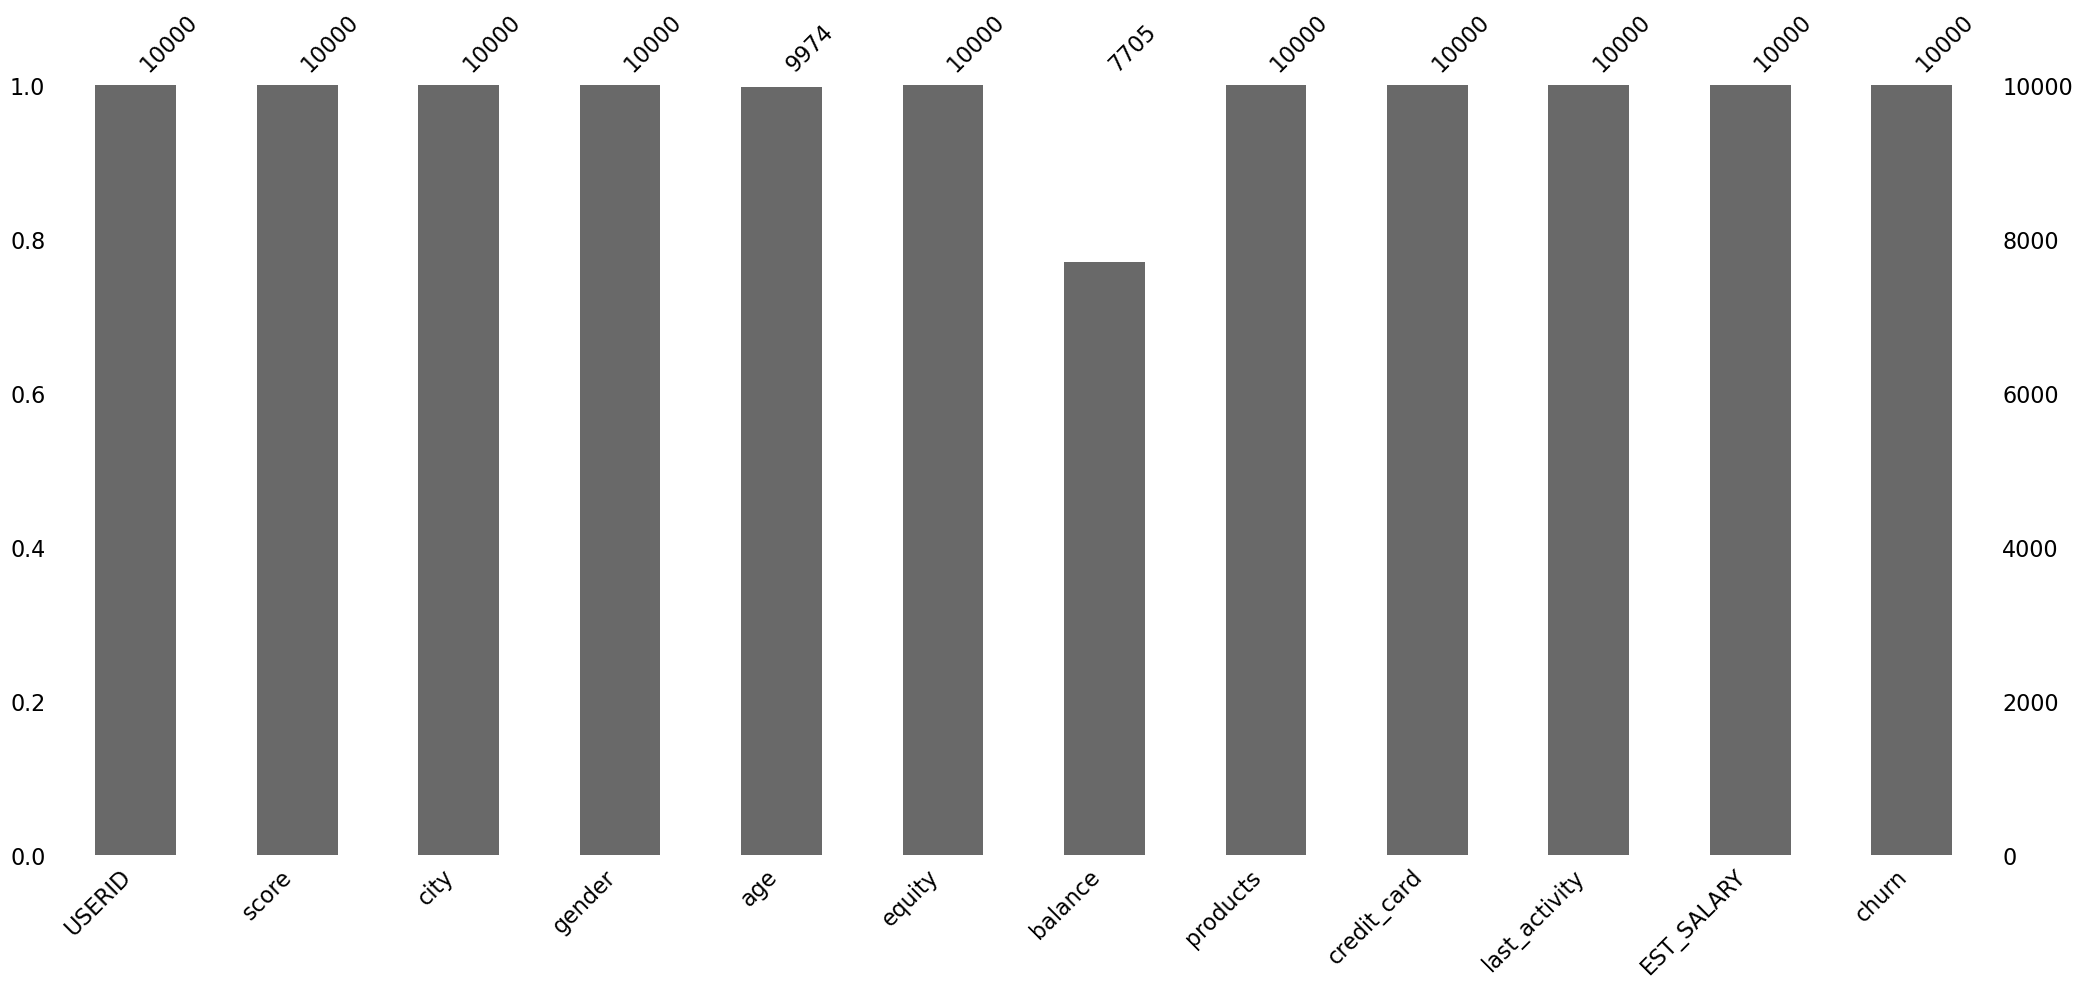

In [4]:
# выведем график по количеству пропусков
msno.bar(data);

Пропуски присутствуют в столбцах age  и balance.

In [5]:
# выведем для просмотра
data.head()   

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


В датасете 1000 строк, 12 столбцов,  желательно изменение названий, необходимо изменений типов данных в столбцах score и age. Имеются пропуски в столбцах age и balance, требующие дополнительного анализа.

### Предобработка

#### Приведение названий столбцов к нижнему регистру, исправление названий.

In [6]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'userid': 'user_id'})

#### Работа с пропусками.

##### Создание дополнительных столбцов для анализа пропусков.

С целью понимания дальнейшей работы с пропусками создадим марицу корреляции пропусков и посмотрим на зависимость пропусков от данных. Для этого создадим дополнительные столбцы, где в столбцах проставим значение 0 для пропуска и 1, если значение имеется.

In [7]:
# создадим  доп. столбцы 
data['age_pass'] = np.where(data['age'].isna(), 0, 1)
data['balance_pass'] = np.where(data['balance'].isna(), 0, 1)

##### Создание матрицы корреляции признаков.

In [8]:
# для корреляции 'user_id' не нужен
data_correlation = data.drop(['user_id'],  axis= 1)

In [9]:
# вычисление матрицы корреляции с использованием phik
corr_matrix = data_correlation.phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary'])

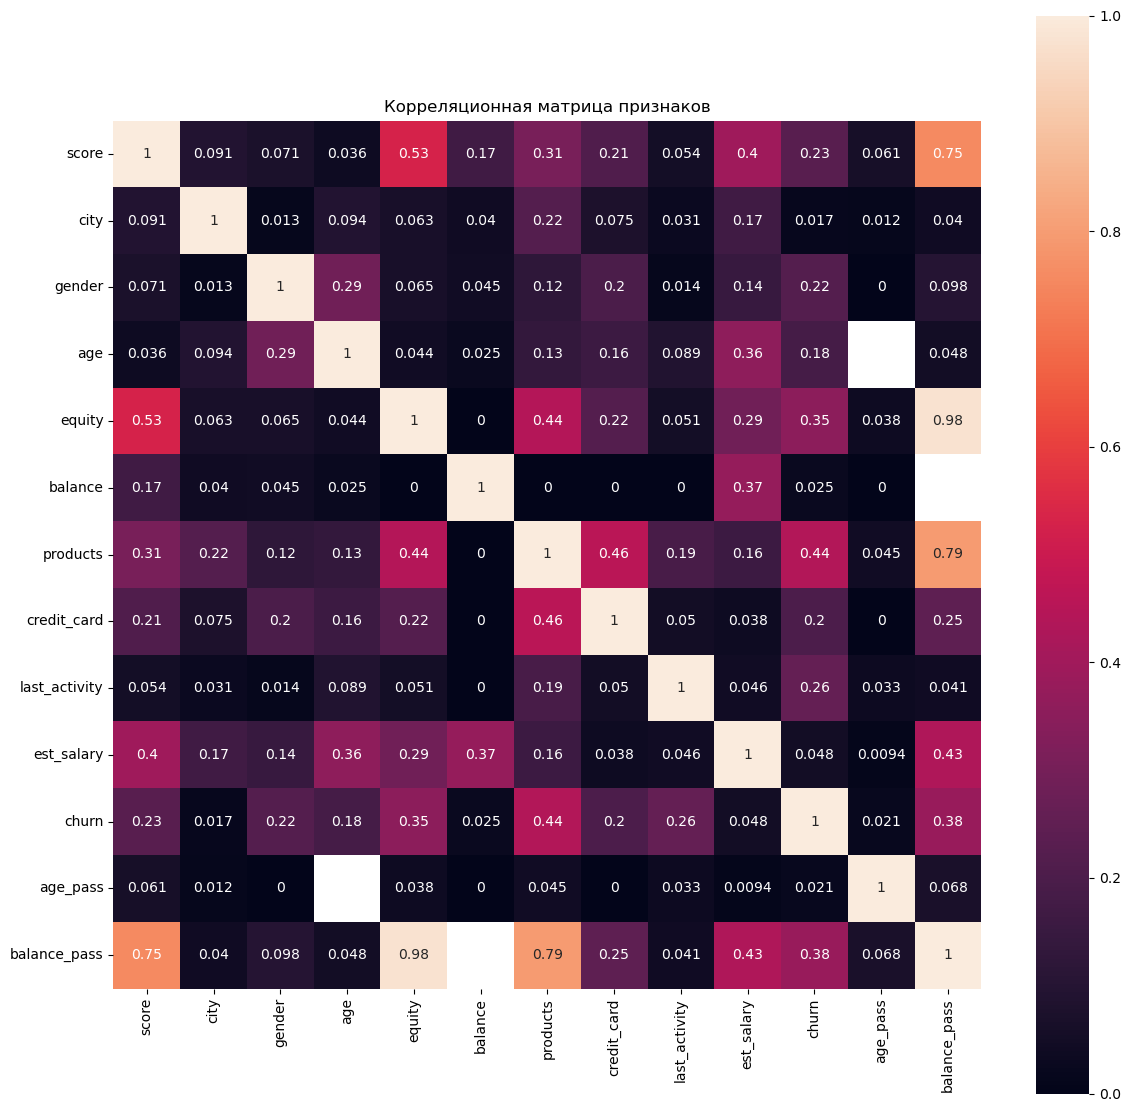

In [10]:
# нарисуем heatmap
plt.figure(figsize = (14,14))
sns.heatmap(corr_matrix, square = True, annot = True )
plt.title('Корреляционная матрица признаков')
plt.show()

Корреляция столбца age_pass с другими признаками полностью отсутствует (по шкале Чеддока 0 – полное отсутствие связи; 0 – 0.3 – очень слабая). Корреляция столбца balance_pass высокая с признаками score, equity, products (высокой по школе Чеддока считается корреляция в диапазоне 0.7-0.9). Выведем график корреляции отдельно по интересующим столбцам.

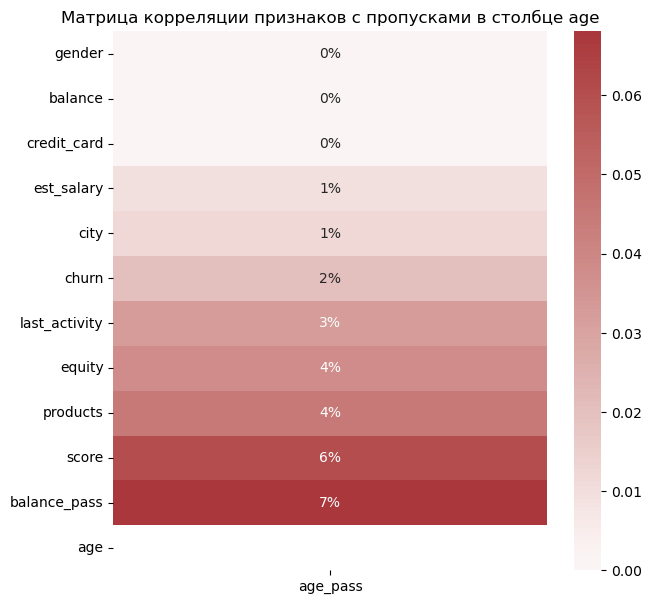

In [11]:
# построим корреляцию признаков с age_pass
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix.loc[:,['age_pass']].drop('age_pass').sort_values('age_pass'), annot=True, fmt=".0%", cmap='vlag', center=0)
plt.title('Матрица корреляции признаков c пропусками в столбце age')
plt.show();

Максимальная корреляция составляет 7%. По шкале Чеддока корреляция в диапазоне от 0 до 30% считается слабой. В нашем случае она отсутствует вовсе.

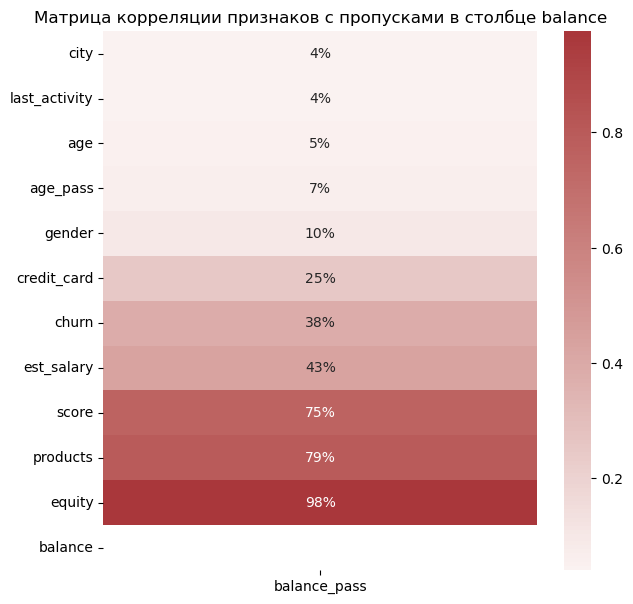

In [12]:
# построим корреляцию признаков с balance_pass
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix.loc[:,['balance_pass']].drop('balance_pass').sort_values('balance_pass'), annot=True, fmt=".0%", cmap='vlag', center=0)
plt.title('Матрица корреляции признаков c пропусками в столбце balance')
plt.show();

Очень высокая корреляция (по шкале Чеддока очень высокая- это 90-100%) пропусков в стобце balance со столбцами equity (98%), products (79%), score (75%). Слабая корреляция (по шкале Чеддока слабая- это 30-50%) пропусков в стобце balance со столбцами est_salary, churn, credit_card. С остальными признаками очень слабая корреляция (по шкале Чеддока 0-30%). Таким образом отмечаем, что в столбце balance высокая корреляция признаков с пропусками.

##### Проверка пропусков по мерам центральной тенеденции.

In [13]:
# выберем непрерывные величины
cont_value = data[['balance_pass', 'score', 'age','est_salary']] 

In [14]:
# построим сводную таблицу
corr_cont_value = (cont_value 
      .pivot_table(index='balance_pass', values=['score', 'age', 'est_salary'], aggfunc='mean')
      .reset_index()
      .round()
)

In [15]:
# добавим столбец для подсчета относительной разницы между величинами оттока и не оттока
corr_cont_value.loc['diff'] = corr_cont_value.loc[0] - corr_cont_value.loc[1]
corr_cont_value

,balance_pass,age,est_salary,score
0,0.0,42.0,226310.0,865.0
1,1.0,43.0,124502.0,844.0
diff,-1.0,-1.0,101808.0,21.0


In [16]:
# выберем дискретные величины
discrete_value = data[['balance_pass', 'equity', 'products', 'credit_card', 'last_activity']]

In [17]:
# построим сводную таблицу
corr_discrete_value = (discrete_value 
            .pivot_table(index='balance_pass', values=['equity', 'products', 'credit_card', 'last_activity'], aggfunc='median')
            .reset_index()
)

In [18]:
# добавим столбец для подсчета относительной разницы между величинами оттока и не оттока
corr_discrete_value.loc['diff'] = corr_discrete_value.loc[1] - corr_discrete_value.loc[0]
corr_discrete_value

,balance_pass,credit_card,equity,last_activity,products
0,0,1,0,1,1
1,1,1,4,1,2
diff,1,0,4,0,1


Разница в средних значениях для непрерывных величин и медианных значений для дискретных величин между группами где отсутствуют/присутствуют значения в столбце balance_pass существенная, что говорит о корреляции. Т.е. существует корреляция между пропусками в столбце balance от имеющихся данных датасета. Корреляции между пропусками в столбце age_pass и данными датасета нет. 

In [19]:
# посмотрим на долю пропусков в столбце age
age_isna = data['age'].isna().sum() / len(data['age'])
print(f'Доля пропусков в столбце age составляет {age_isna:.2%}.')

Доля пропусков в столбце age составляет 0.26%.


Корреляции пропусков с данными датасета нет, доля меньше 0,26%, ошибка пропусков по классификации MCAR (Missing Completely At Random / Отсутствует совершенно случайно). Удалим пропуски по столбцу age.

In [20]:
# удалим пропуски
data = data.dropna(subset=['age']).reset_index(drop=True)  

In [21]:
# посмотрим на долю пропусков в столбце balance
balance_isna = data['balance'].isna().sum() / len(data['balance'])
print(f'Доля пропусков в столбце balance составляет {balance_isna:.2%}.')

Доля пропусков в столбце balance составляет 22.85%.


In [22]:
# выведем строки с пропущенными значениями в столбце balance
data[data['balance'].isna()] 

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
9,133130,906,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0
10,148929,927,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,1,0
11,172184,921,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,1,0
19,127034,922,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,208085,876,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0,1,0
9958,125941,729,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0,1,0
9967,219924,884,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0,1,0
9970,139170,894,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,1,0


Отметим, что клиенты, у которых нет данных по балансу пользуются, как правило, одним продуктом банка, у них нет собственности, зачастую есть кредитная карта и они не планируют перестать быть клиентами банка. Судя по параметрам, предположительно, это клиенты, взявшие кредит под ипотеку (1 продукт) и недвижимость в залоге банка (нет собственности). Баланс на счете пополняется под ипотечное списание и после списания дебетовой картой не пользуются. Или списание с кредитных карт. Пропуски в столбце balance относятся к категории MNAR (Missing Not At Random / Отсутствует не случайно). Заменим пропуски на ноль. 

In [23]:
data['balance'] = data['balance'].fillna(0) 

#####  Анализ гистограмм распределения признаков у клиентов с нулевым балансом.

Построим гистограммы по числовым параметрам клиентов, имеющих нулевой баланс (замененные пропуски).

In [24]:
# сделаем срез
data_balance_zero =  data.query('balance == 0')

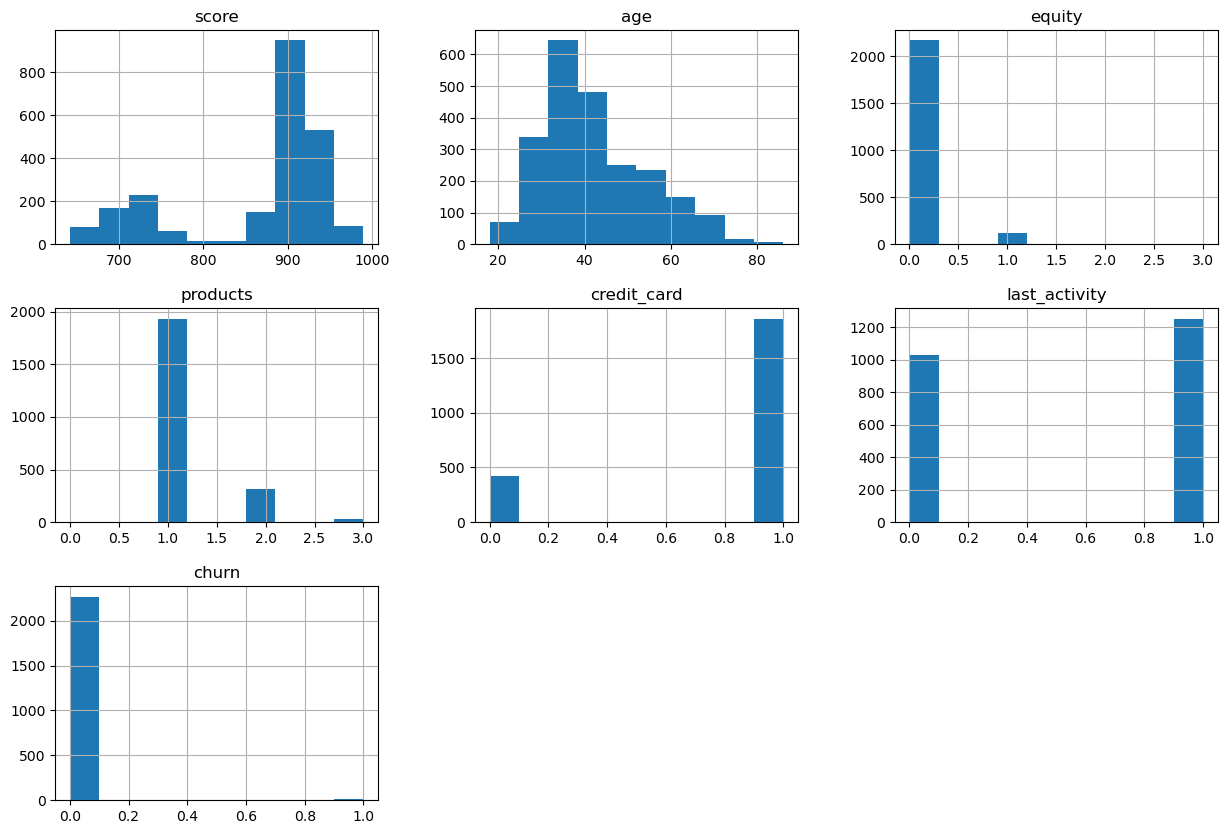

In [25]:
# построим гистограммы
data_balance_zero[['score', 'age', 'equity', 'products', 'credit_card', 'last_activity', 'churn']].hist(figsize=(15,10));

По графикам подтверждаются выводы выше, что нулевой баланс у клиентов, которые не склонны к оттоку, регулярно осуществляют банковские операции, имеют кредитные карты, пользуются одним продуктом, не имеют собственности, в возрасте 30-40 лет.

#### Изменение типов данных.

In [26]:
# изменим тип данных
data = data.astype({'age':'int', 'score':'int' },errors='ignore')

#### Кодирование переменных.

In [27]:
# сделаем копию столбца
data['city_copy'] = data['city'].copy()

In [28]:
# закодируем 
data = pd.get_dummies(data, columns=['city'])

In [29]:
# сделаем копию столбца
data['gender_copy'] = data['gender'].copy()

In [30]:
# закодируем 
data = pd.get_dummies(data, columns=['gender'])

In [31]:
data.head() # проверим

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
0,183012,850,25,1,59214.82,2,0,1,75719.14,1,1,1,Рыбинск,0,1,0,Ж,1,0
1,146556,861,37,5,850594.33,3,1,0,86621.77,0,1,1,Рыбинск,0,1,0,Ж,1,0
2,120722,892,30,0,0.00,1,1,1,107683.34,0,1,0,Рыбинск,0,1,0,Ж,1,0
3,225363,866,51,5,1524746.26,2,0,1,174423.53,1,1,1,Ярославль,0,0,1,Ж,1,0
4,157978,730,34,5,174.00,1,1,0,67353.16,1,1,1,Ярославль,0,0,1,М,0,1


#### Работа с дубликатами.

In [32]:
# проверим наличие полных дубликатов 
data.duplicated().sum()

0

In [33]:
# проверим наличие  дубликатов по выбранным столбцам
data.duplicated(subset=['user_id', 'city_copy', 'gender_copy', 'age' ]).sum()

0

Как правило user_id - это уникальны номера, проверим так ли это.

In [34]:
data['user_id'].value_counts()

195884    2
117943    2
220816    2
185748    2
126368    2
         ..
125665    1
125361    1
199413    1
205705    1
96267     1
Name: user_id, Length: 9924, dtype: int64

In [35]:
data.duplicated(subset=['user_id']).sum()

50

Нашлось 50 дубликатов.

In [36]:
data[data.duplicated(subset=['user_id'], keep=False)].sort_values('user_id')  # посмотрим 

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
1892,116540,883,55,1,362756.49,3,0,1,175920.48,1,1,1,Рыбинск,0,1,0,Ж,1,0
7683,116540,887,38,0,0.00,1,0,1,119247.61,0,1,0,Ярославль,0,0,1,Ж,1,0
4862,117943,855,32,6,1036832.93,4,1,1,107792.71,1,1,1,Рыбинск,0,1,0,Ж,1,0
7531,117943,880,40,0,0.00,1,1,0,137718.93,0,1,0,Ярославль,0,0,1,Ж,1,0
5856,120258,908,38,4,2213581.63,2,0,1,160327.77,1,1,1,Рыбинск,0,1,0,Ж,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,220816,934,74,5,1294285.39,3,1,0,95606.80,0,1,1,Рыбинск,0,1,0,Ж,1,0
2594,226719,990,37,4,14648692.14,2,0,0,934412.61,1,1,1,Ярославль,0,0,1,М,0,1
4212,226719,903,63,0,0.00,1,1,0,138582.58,0,1,0,Рыбинск,0,1,0,Ж,1,0
8192,227795,840,34,2,350768.03,1,1,0,102036.14,1,1,1,Рыбинск,0,1,0,М,0,1


В парах строк с одинаковым user_id остальные параметры разные. Зафиксируем, что в датасете имеется 50 повторяющихся user_id, при этом это 100 разных клиентов. Учтем это при анализе.

#### Анализ гистограмм по числовым параметрам датасета.

Изучим по гистограммам числовые параметры.

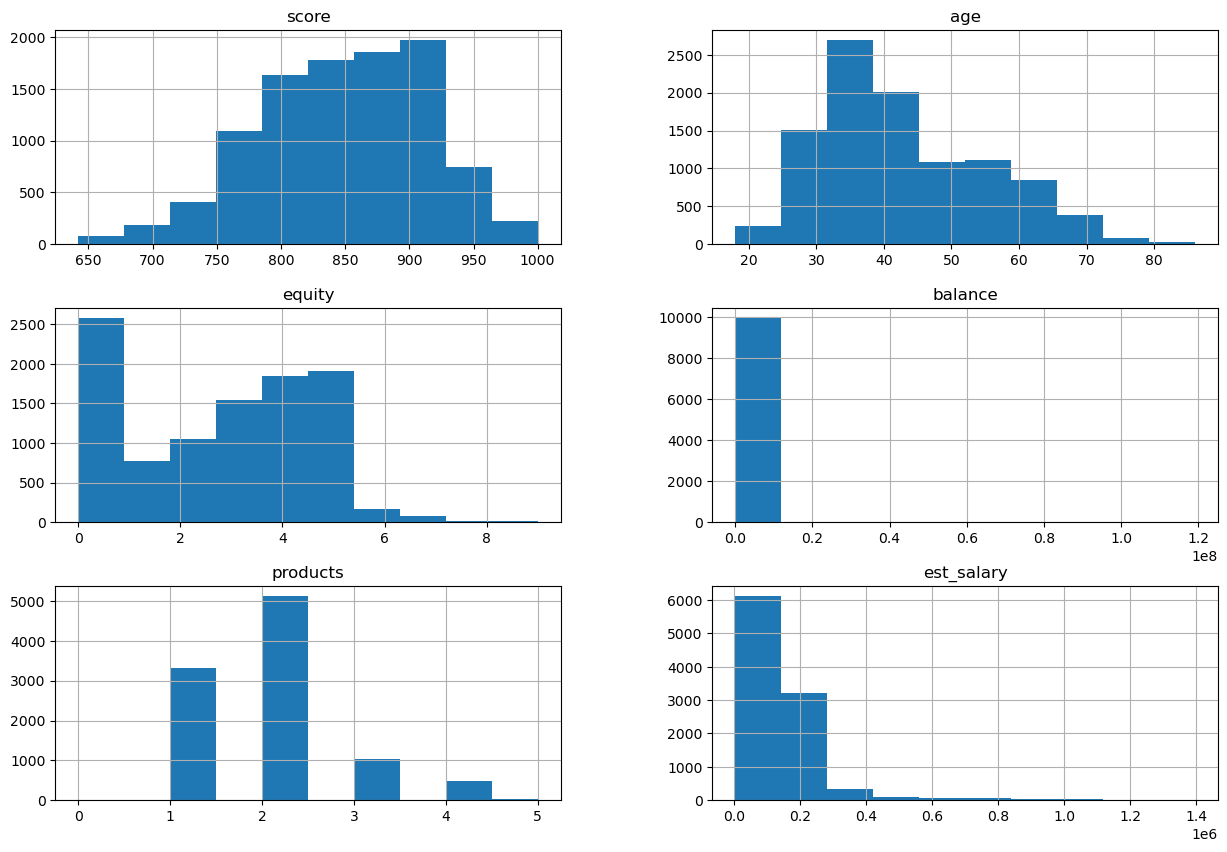

In [37]:
data[['score', 'age', 'equity', 'balance', 'products', 'est_salary']].hist(figsize=(15,10));

Баллы скоринга от 650 до 1000, в основном в диапазоне 800-900. Возраст клиентов от 18 до 86 лет (можно дополнительно проверить, т.к. верхний порог большой). По наличию собственности пик приходится на ноль (нет собственности), в основном 3-5 единиц собственности, хвост свыше 8. В балансе есть одиночные значения выбросов. Количество продуктов банка - в основном 2 (диапазон от 1 до 5). По доходу тоже имеются выбросы.

In [38]:
# проверим возраст, сделаем срез больше 80
data_old_сlient = data.query('age > 80')
data_old_сlient

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
1620,151166,916,83,0,0.00,1,1,1,55681.82,0,1,0,Рыбинск,0,1,0,Ж,1,0
1986,219132,827,82,3,275391.31,2,0,0,59205.90,0,1,1,Рыбинск,0,1,0,Ж,1,0
2062,115610,823,81,2,139576.56,2,0,1,146201.01,0,1,1,Ярославль,0,0,1,Ж,1,0
2792,214518,820,83,3,1137456.03,3,0,0,18037.97,0,1,1,Ярославль,0,0,1,Ж,1,0
3268,207759,888,84,3,1287558.90,2,0,1,97982.17,0,1,1,Ярославль,0,0,1,Ж,1,0
4383,117913,658,81,0,0.00,1,1,1,105088.10,0,1,0,Рыбинск,0,1,0,Ж,1,0
5595,151854,707,81,0,0.00,1,1,0,102360.77,0,1,0,Ярославль,0,0,1,Ж,1,0
5666,147965,854,81,3,803337.98,2,0,1,50386.82,0,1,1,Ярославль,0,0,1,Ж,1,0
8224,208065,785,82,2,1221645.78,3,1,1,66059.88,0,1,1,Рыбинск,0,1,0,Ж,1,0
9157,116838,777,86,3,772929.83,1,1,1,40877.18,0,1,1,Ярославль,0,0,1,Ж,1,0


Ничего необычного в срезе данных нет, есть активность, дебетовые счета, кредитки. 

Проверим корректность датасета на условие, что все клиенты банка действующие, т.е. имеют как минимум один продукт.

In [39]:
data['products'].unique()

array([2, 3, 1, 4, 5, 0], dtype=int64)

Есть нулевое значение. Проверим что это.

In [40]:
data.query('products == 0')

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
8939,147837,962,79,3,0.0,0,0,0,25063.96,1,1,0,Рыбинск,0,1,0,Ж,1,0


Женщина 79 лет без денег на счете, не имеет банковских продуктов, не имеет кредитной карты и активности, при этом у неё признак оттока. Это техническая ошибка, удалим.

In [41]:
data = data.query('products != 0')

####  Работа с выбросами.

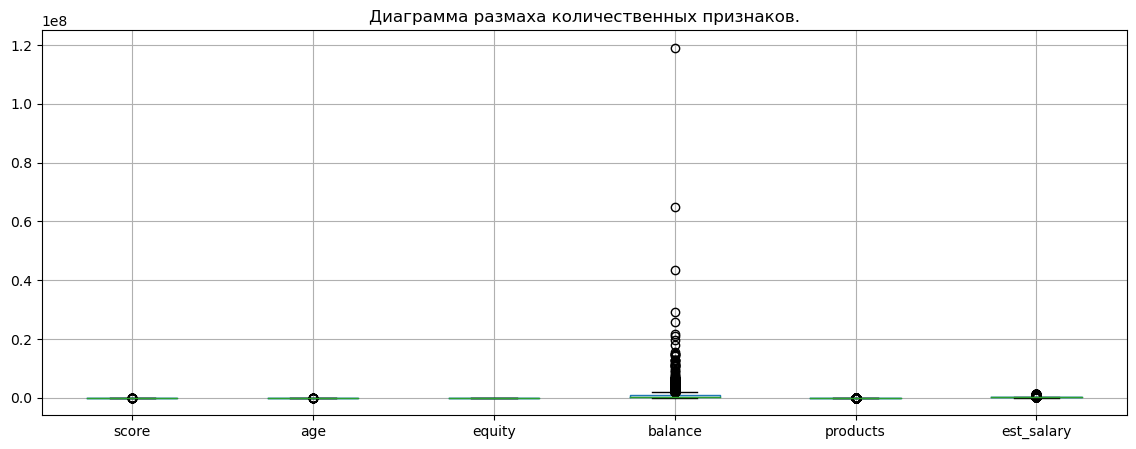

In [42]:
# построим диаграммы размаха 
plt.figure(figsize=(14, 5))
boxplot = data.boxplot(column=['score', 'age', 'equity', 'balance', 'products', 'est_salary']) 
plt.title("Диаграмма размаха количественных признаков.");

Выбросы в столбцах 'balance' и 'est_salary'.

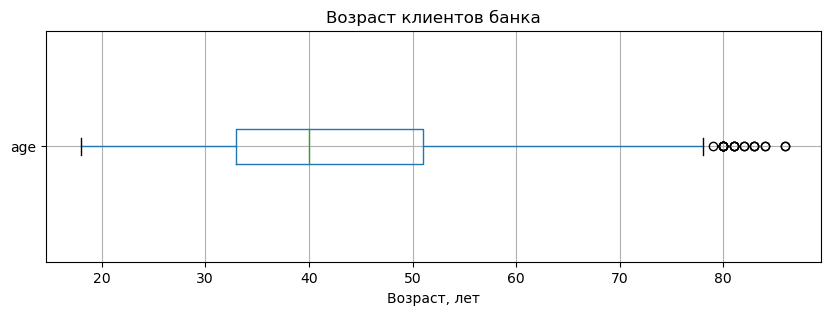

In [43]:
# посмотрим детально
data.boxplot(column='age', figsize=(10,3), vert = False) # Построим диаграмму размаха
plt.title("Возраст клиентов банка")
plt.xlabel("Возраст, лет")

plt.show()

Встречаются значения возраста от 78 и выше.

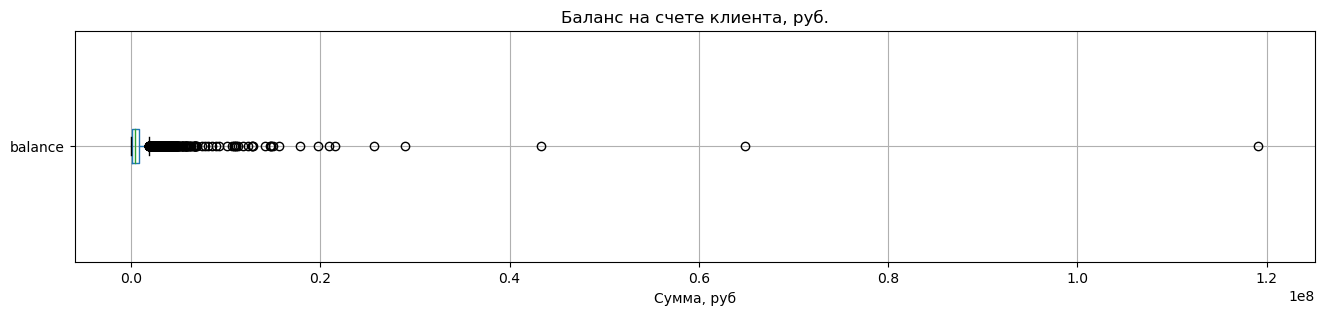

In [44]:
data.boxplot(column='balance', figsize=(16,3), vert = False) # Построим диаграмму размаха
plt.title("Баланс на счете клиента, руб.")
plt.xlabel("Сумма, руб")

plt.show()

In [45]:
data['balance'].max()

119113552.0

In [46]:
# посмотрим на данные, сделаем срез от 40 млн.
data_big_balance = data.query('balance > 40000000')
data_big_balance

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
1059,114103,894,58,4,6.486621e+07,2,1,1,88861.60,1,1,1,Ярославль,0,0,1,М,0,1
1845,114088,927,57,5,4.327710e+07,3,0,1,82619.00,0,1,1,Ярославль,0,0,1,М,0,1
7586,156149,900,62,5,1.191136e+08,2,1,1,138041.31,0,1,1,Ярославль,0,0,1,М,0,1


Средневозрастные мужчины из Ярославля со средним доходом,имеющие большой балл собственности. Максимальный уровень баланса 119 млн. руб.

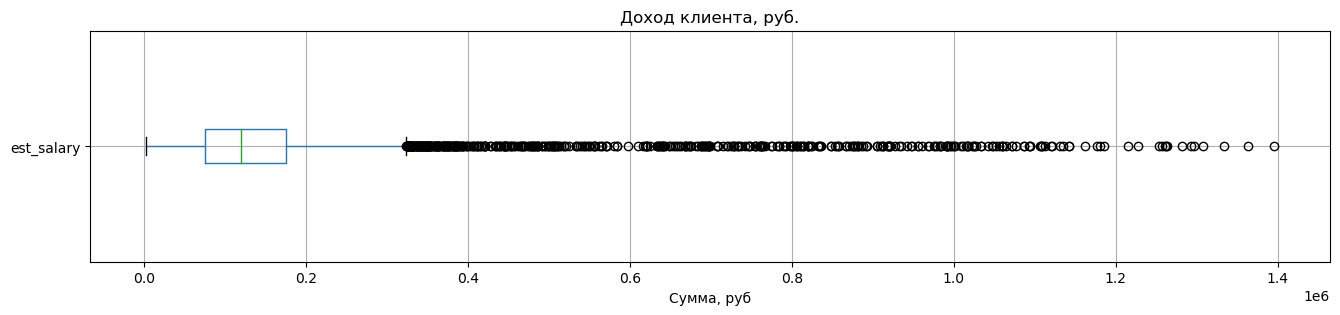

In [47]:
# построим диаграмму размаха по доходу
data.boxplot(column='est_salary', figsize=(16,3), vert = False) 
plt.title("Доход клиента, руб.")
plt.xlabel("Сумма, руб")
plt.show()

In [48]:
# выведем для просмотра срез
data_high_salary = data.query('est_salary > 1200000')
data_high_salary

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_pass,balance_pass,city_copy,city_Ростов,city_Рыбинск,city_Ярославль,gender_copy,gender_Ж,gender_М
149,218801,958,34,0,0.00,1,1,0,1292825.74,0,1,0,Ярославль,0,0,1,М,0,1
302,164876,942,40,0,0.00,1,1,0,1256537.74,0,1,0,Ярославль,0,0,1,М,0,1
1027,119793,1000,50,5,12909691.02,1,1,0,1253653.40,0,1,1,Ярославль,0,0,1,М,0,1
1467,162749,940,32,2,4508306.65,2,1,0,1260919.56,0,1,1,Ярославль,0,0,1,М,0,1
1599,197637,785,41,0,0.00,1,1,0,1307090.18,0,1,0,Ярославль,0,0,1,М,0,1
3366,140920,741,46,0,0.00,1,1,1,1214615.32,0,1,0,Ярославль,0,0,1,Ж,1,0
4001,163640,912,35,4,15624095.80,2,0,1,1395064.45,0,1,1,Ярославль,0,0,1,М,0,1
4469,216422,956,27,0,0.00,1,1,0,1333687.36,0,1,0,Ярославль,0,0,1,М,0,1
4633,149430,961,37,5,4054667.81,3,0,0,1363549.52,0,1,1,Ярославль,0,0,1,М,0,1
5155,174746,731,30,0,0.00,2,1,0,1296838.08,0,1,0,Ярославль,0,0,1,Ж,1,0


Клиенты снова из Ярославля, обоих полов, часть из них ипотечники как мы выяснили ранее. Часть из них, имея высокий доход держит деньги на счете, пользуется другими продуктами банка.

#### Анализ графиков по категориальным параметрам датасета.

In [49]:
def cat_graph(data):
    list_cat = ["credit_card", "last_activity", "churn", "city_copy", "gender_copy"]
    for i in list_cat:
        print('График по категориальному параметру', i)
        data[i].value_counts().plot.bar(grid=True)
        plt.xlabel(i)
        plt.ylabel("value")
        plt.show()
        print()
        print()

График по категориальному параметру credit_card


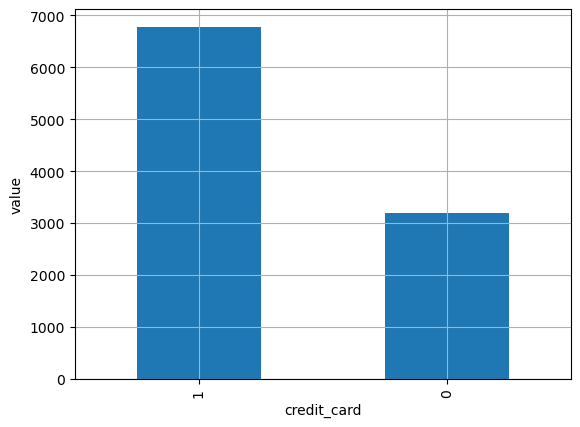



График по категориальному параметру last_activity


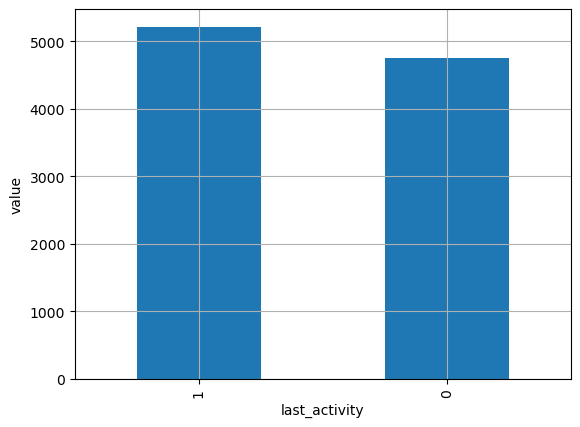



График по категориальному параметру churn


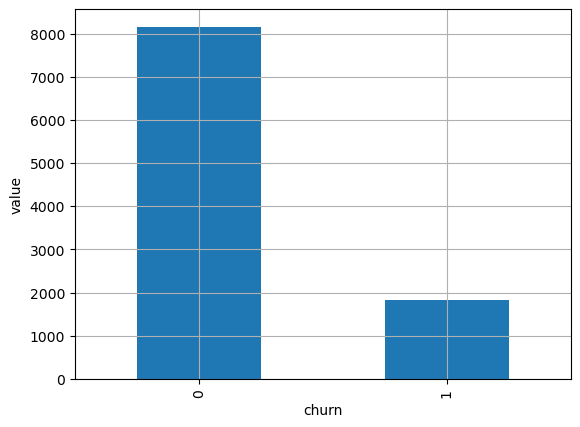



График по категориальному параметру city_copy


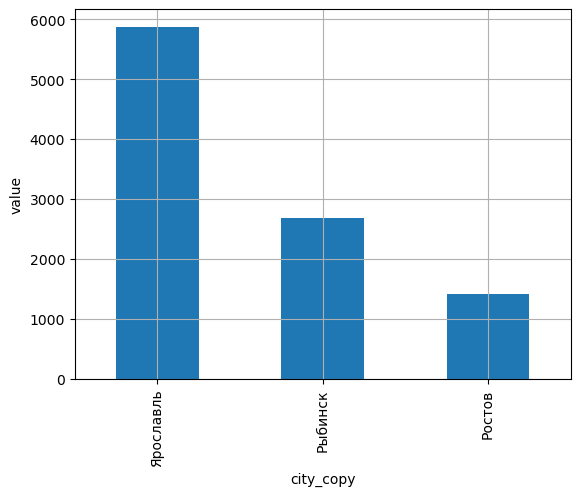



График по категориальному параметру gender_copy


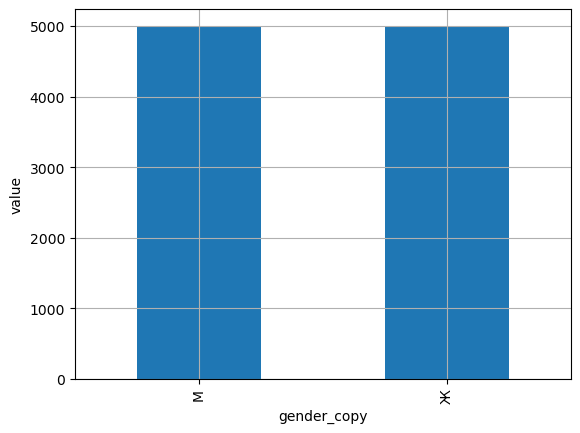

In [50]:
cat_graph(data)

Кредитные карты имеют приблизительно половина клиентов банка. Количество неактивных/активных клиентов практически одинаковое. Доля клиентов склонных к оттоку около 1/4, подробно будет рассмотрена позже в анализе. Территориально клиенты из Ярославля, Рыбинска, Ростова (по убыванию) Число мужчин и женщин одинаковое.

В результате предобработки мы изменили типы данных по двум столбцам. Изучили количество пропусков и их корреляцию с остальными признаками, удалили пропуски в столбце age по причине малой доли и полного отсутствия корреляции с остальными признаками. Но в столбце balance пропуски заменили на ноль, т.к. была выявлена высокая корреляция с некоторыми признаками. Изучили дубликаты и нашли 50 неявных дубликатов в user_id, оставили их, т.к. при одинаковых user_id остальные признаки разные. Подготовили данные для исследовательского анализа.   

### Исследовательский анализ данных.

#### Оценка долей сегментов оттока.

In [51]:
# удалим столбцы, что использовали для анализа пропусков
data.drop(['age_pass', 'balance_pass'],  axis= 1 , inplace= True) 

In [52]:
# найдем долю оттока
data_churn = round(data['churn'].value_counts()/len(data['churn']),2).reset_index()
data_churn.columns = 'Отток','Доля' 

data_churn['Отток'] = data_churn['Отток'].replace ({0:"Не отток", 1:"Отток"})

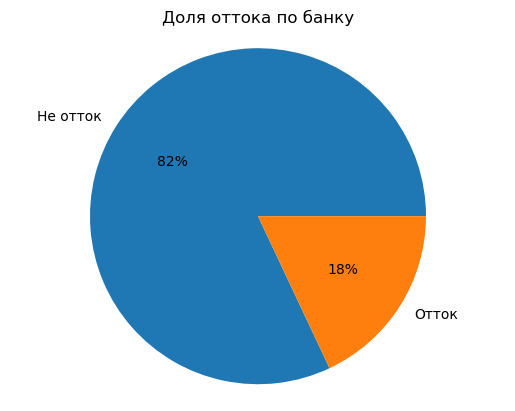

In [53]:
# построим круговую диаграмму
vals = [82, 18]
labels = ['Не отток', 'Отток']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.0f%%')
ax.axis("equal")
plt.title('Доля оттока по банку');


Зафиксируем, что доля оттока составляет 18%.

#### Меры центральных тенденций оттока/не отттока.

In [54]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,9973.000000,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,171757.616966,848.671212,42.730773,2.630803,6.382889e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292,0.141983,0.268926,0.589091,0.499549,0.500451
std,33696.365256,65.393153,12.175166,1.980060,1.773823e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105,0.349051,0.443424,0.492024,0.500025,0.500025
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,142757.000000,802.000000,33.000000,0.000000,6.288953e+04,1.000000,0.000000,0.000000,7.525202e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,3.763121e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,201164.000000,900.000000,51.000000,4.000000,8.044834e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим таблицу мер центральных тенеденций  с вычислением разницы между оттоком и не оттоком. При этом по столбцам, где есть выбросы будем смотреть также медиану.

In [55]:
measures = data.groupby('churn').agg({'age':'mean', 'score':'mean', 'balance':['mean', 'median'],  'est_salary':['mean', 'median'],
                                      'equity':'median', 'products':'mean'}).round()
             
measures = measures.append(measures.diff(), ignore_index=True).dropna()                           

C:\Users\HP\AppData\Local\Temp\ipykernel_14048\1005257282.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  measures = measures.append(measures.diff(), ignore_index=True).dropna()


In [56]:
measures['gender_moda']=[mode(data[data['churn']==0]['gender_copy']), mode(data[data['churn']==1]['gender_copy']),'']
measures['city_moda']=[mode(data[data['churn']==0]['city_copy']), mode(data[data['churn']==1]['city_copy']),'']

In [57]:
measures = measures.reset_index()

In [58]:
measures.columns='Отток','Возраст, ср.','Скоринг, ср.', 'Баланс, ср.', 'Баланс, мед.', 'Доход, ср.', 'Доход, мед.', 'Баллы собственности, мед.', 'Кол-во продуктов, ср.', 'Пол, мода','Город, мода'


In [59]:
measures['Отток'] = measures['Отток'].replace({0:'Не отток', 1:'Отток', 3: 'Разница'})

In [60]:
measures = measures.T

In [61]:
measures.columns='','',''

In [62]:
print()
print('Меры центральной тенденции по параметрам между сегментами отток/неотток')
measures


Меры центральной тенденции по параметрам между сегментами отток/неотток


,,,
Отток,Не отток,Отток,Разница
"Возраст, ср.",43.0,41.0,-2.0
"Скоринг, ср.",845.0,863.0,18.0
"Баланс, ср.",529347.0,1126970.0,597623.0
"Баланс, мед.",321643.0,775399.0,453756.0
"Доход, ср.",147675.0,148357.0,682.0
"Доход, мед.",118228.0,125409.0,7181.0
"Баллы собственности, мед.",3.0,4.0,1.0
"Кол-во продуктов, ср.",2.0,2.0,0.0
"Пол, мода",Ж,М,


Наблюдаем существенную разницу между оттоком и не оттоком в балансе (по значению медианы). По доходу (по значению медианы) в целом разница незначительная. По остальным показателям разница также незначительная. Количество продуктов банка и город - одинаковые. По оттоку мода пола - мужской пол. Отметим для дальнейшего анализа оттока категории с относительной разницей: возраст, скоринг, баланс, баллы собственности, пол.

#### Анализ распределения признаков в разрезе оттока.

Построим нормированные графики по каждому признаку и посмотрим при каких значениях признака отток превышает или равен не оттоку.

##### По признаку 'баллы скоринга'

In [63]:
# переименуем столбцы для удобства
data_new = data.rename(columns={'score': 'баллы скоринга', 'age': 'возраст', 'equity': 'оценка собственности','balance': 'баланс', 'products': 'количество продуктов','credit_card': 'кредитная карта','last_activity': 'активность клиента', 'est_salary': 'доход', 'churn': 'отток', 'city_copy': 'город', 'gender_copy': 'пол'})


In [64]:
data_new['отток'] = data_new['отток'].replace({0:'не отток', 1:'отток'})

In [65]:
# напишем функцию для вывода графиков числовых категорий
def num_value(df, col, name):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 5))
    sns.kdeplot(data=df, x=col, hue=df['отток'], common_norm=False)
    plt.title("Распределение клиентов по признаку:" + name)
    plt.xlabel(name)
    plt.ylabel('плотность распределения')
    plt.show();

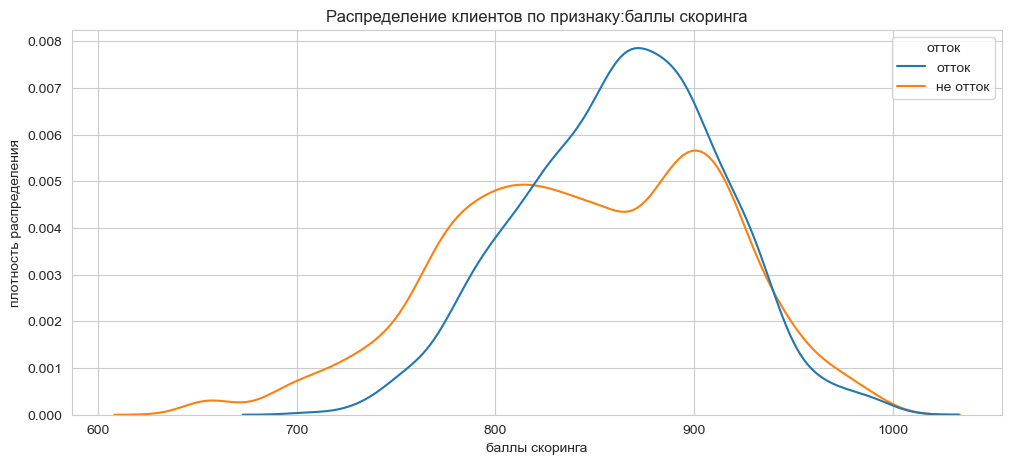

In [66]:
num_value(data_new, data_new['баллы скоринга'], "баллы скоринга")

По признаку 'баллы скоринга'
- отток в диапазоне от 810 до 950

##### По признаку 'возраст'

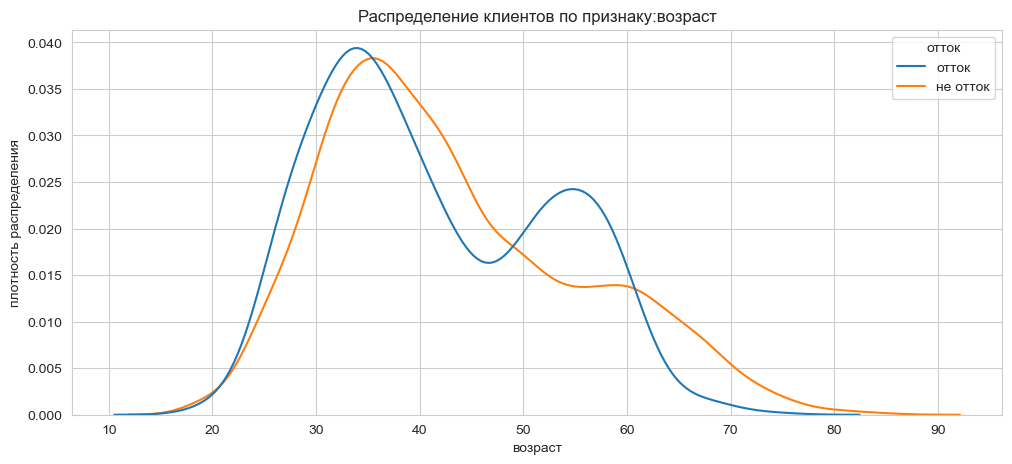

In [67]:
num_value(data_new, data_new['возраст'], "возраст")

По признаку 'возраст' 
- отток в диапазоне  22-33 года, 49-60 лет.

##### По признаку 'доход'

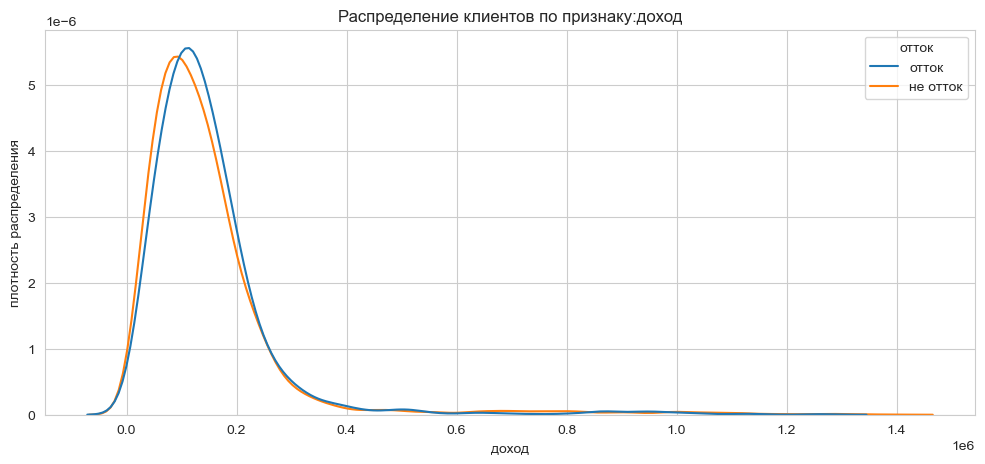

In [68]:
num_value(data_new, data_new['доход'], "доход")

По обоим категориям оттока пик приходится на значения около 100 тыс.

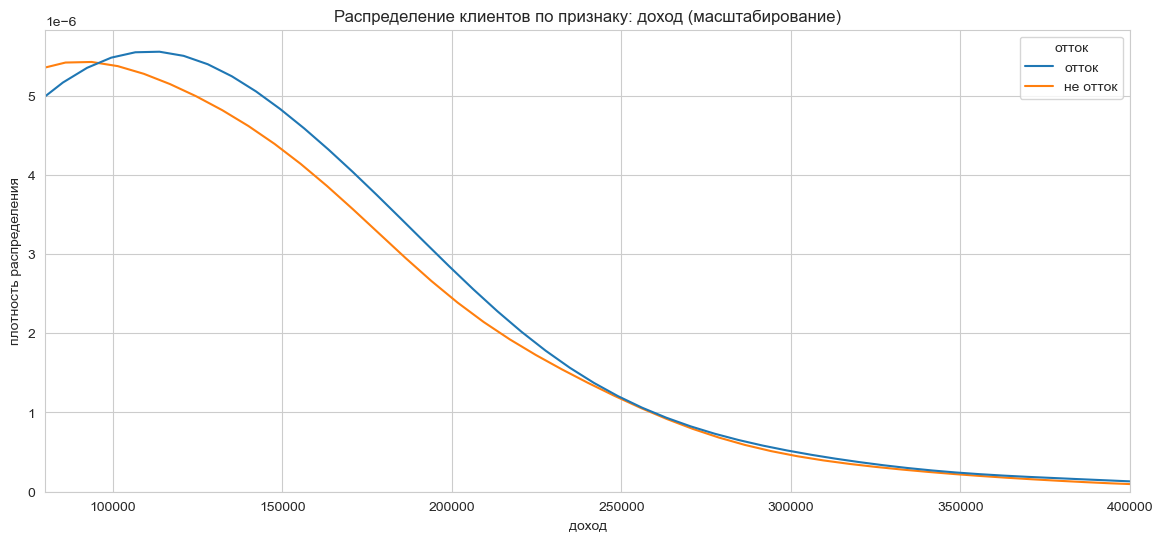

In [69]:
# масштабируем
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.kdeplot(data=data_new, x='доход', hue='отток', common_norm=False)
plt.title("Распределение клиентов по признаку: доход (масштабирование)")
plt.xlabel("доход")
plt.ylabel('плотность распределения')
plt.xlim(80000, 400000)
plt.show();

В диапазоне от 100 тыс и выше отток выше или на том же уровне, посмотрим хвост.

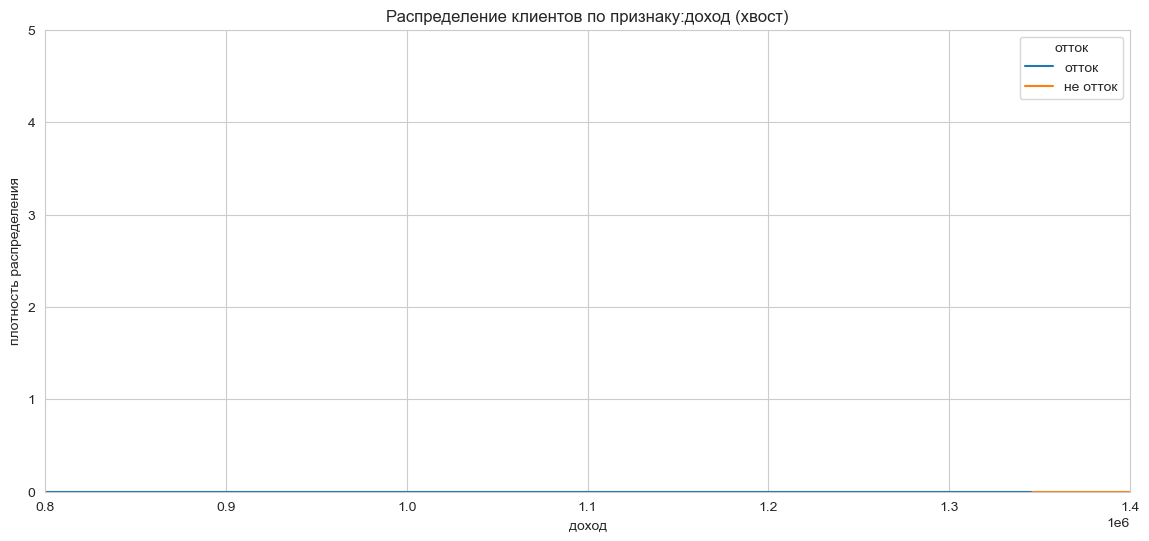

In [70]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
sns.kdeplot(data=data_new, x='доход', hue='отток', common_norm=False)
plt.title("Распределение клиентов по признаку:доход (хвост)")
plt.xlabel("доход")
plt.ylabel('плотность распределения')
plt.xlim(800000, 1400000)
plt.ylim(0, 5)
plt.show();

Никаких всплесков или превышений.

По признаку 'доход' 
- отток в диапазоне от 100 тыс. до 1400 тыс.

##### По признаку 'баланс'

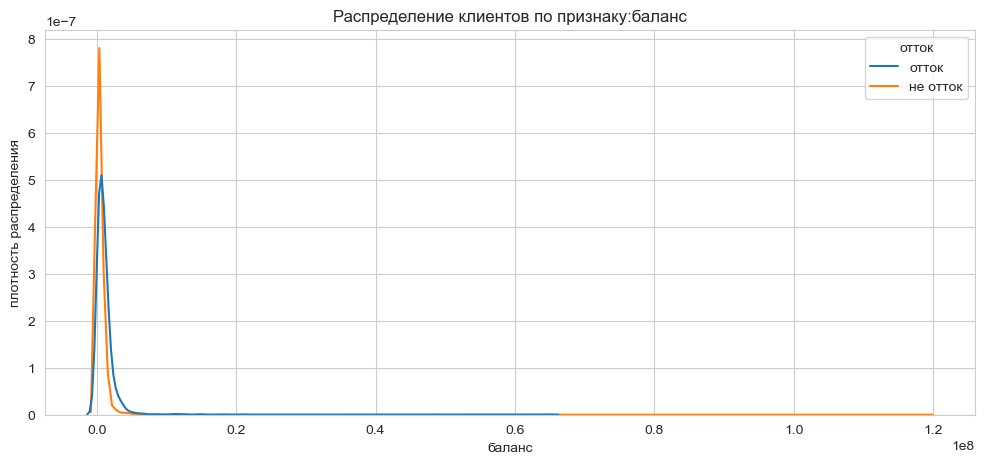

In [71]:
num_value(data_new, data_new['баланс'], "баланс")

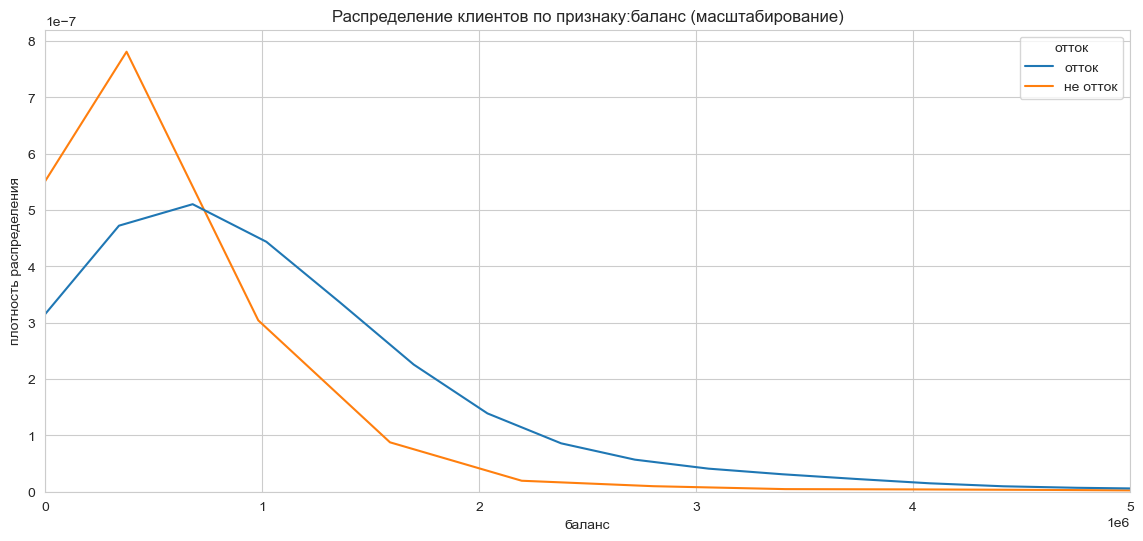

In [72]:
sns.set_style('whitegrid')
plt.figure(figsize=(14, 6))
sns.kdeplot(data=data_new, x='баланс', hue='отток', common_norm=False)
plt.title("Распределение клиентов по признаку:баланс (масштабирование)")
plt.xlabel("баланс")
plt.ylabel('плотность распределения')
plt.xlim(0, 5000000)
#plt.ylim(0, 5)
plt.show();

Основная масса клиентов имеет вклады до 800 тыс.

По признаку 'баланс' 
- отток в диапазоне от 800 тыс. до 120 млн.

##### По признаку 'кредитная карта'

In [73]:
# напишем функцию для вывода графиков по категориальным признакам
def cat_value(data, col, name):
    df = data.groupby(col)['churn'].agg(['sum', 'count']).reset_index()
    df.columns = 'Признак', 'Отток', 'Кол-во'
    df['Признак'] = df['Признак'].replace({0:'Нет', 1:'Да'})
    df['Доля'] = round(df['Отток']/df['Кол-во']*100)
    df = df.sort_values(by='Доля', ascending=False)
    
    ax = df.plot.bar(x='Признак', y='Доля', figsize=(12, 5), grid=True)
   
     # оформляем график
    plt.title('Доля отточных клиентов по признаку: ' + name) 
    plt.xlabel(name)
    plt.ylabel('доля, %')
    plt.xticks(rotation=0)
    ax.get_legend().remove()
    plt.axhline(y=18, color='firebrick', linestyle='--')

    plt.show() # выводим график


Пунктирной линией на графиках обозначим уровень оттока по банку 18%. 

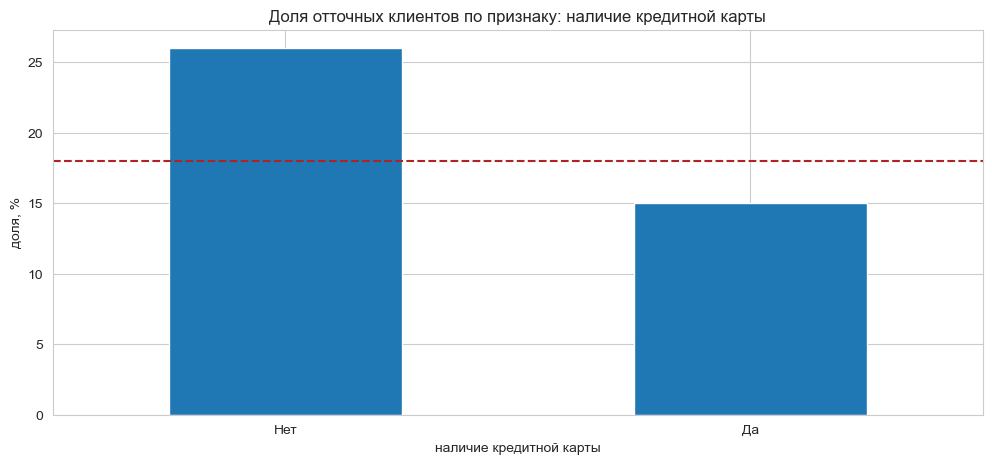

In [74]:
cat_value(data, data['credit_card'], 'наличие кредитной карты')

По признаку 'кредитная карта' 
- отток у клиентов, не имеющих кредитной карты

##### По признаку 'активность клиента'

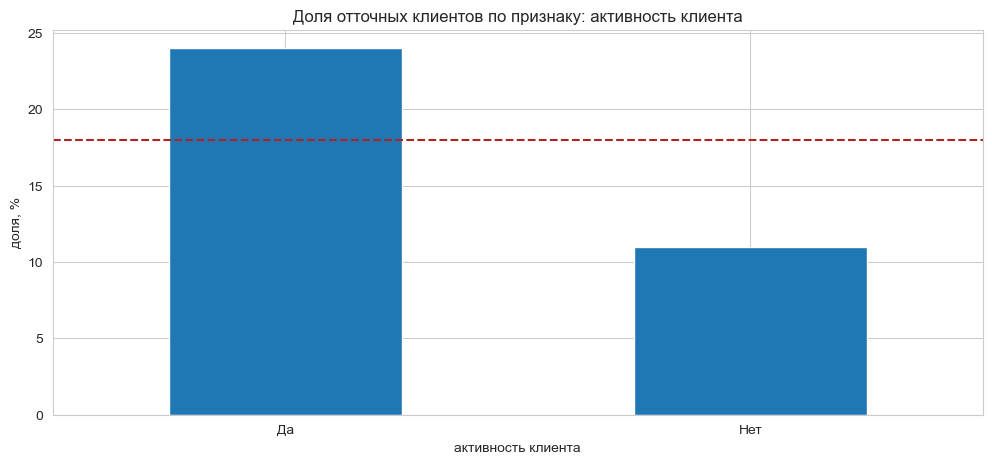

In [75]:
cat_value(data, data['last_activity'], 'активность клиента')

По признаку 'активность клиента' 
- отток у клиентов, проявляющих активность

##### По признаку 'город'

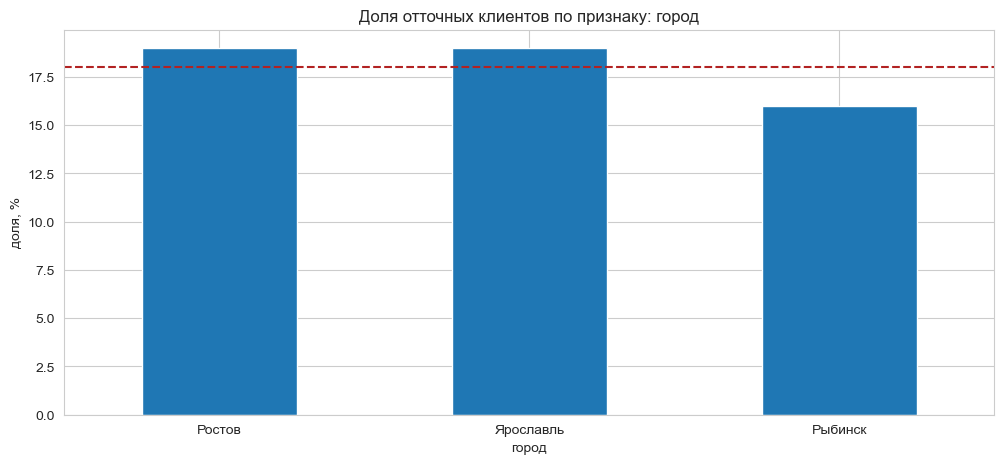

In [76]:
cat_value(data, data['city_copy'], 'город')

По признаку 'город' 
- отток клиентов из Ростова и Ярославля.

##### По признаку 'пол'

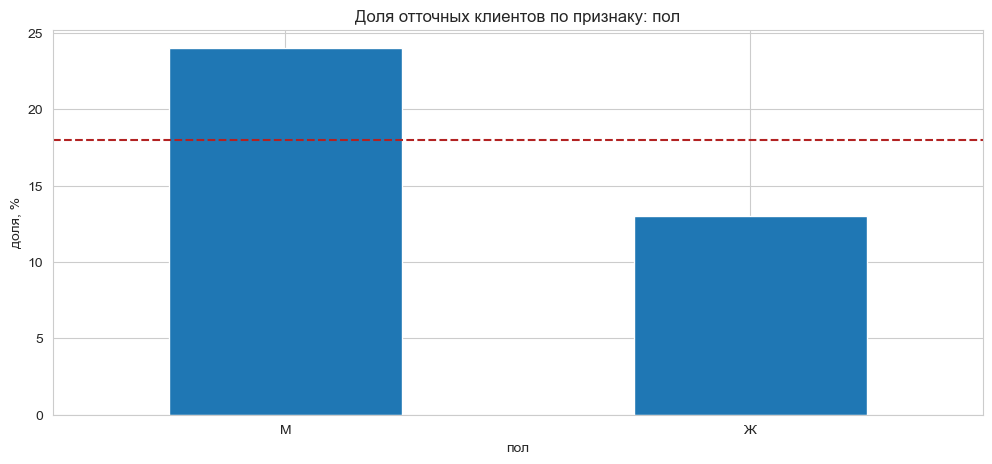

In [77]:
cat_value(data, data['gender_copy'], 'пол')

По признаку 'пол' 
- отток клиентов мужского пола.

##### По признаку 'баллы собственности'.

In [78]:
def cat_add_value(data, col, name):
    df = data.groupby(col)['churn'].agg(['sum', 'count']).reset_index()
    df.columns = 'Признак', 'Отток', 'Кол-во'
    #df['Признак'] = df['Признак'].replace({0:'Нет', 1:'Да'})
    df['Доля'] = round(df['Отток']/df['Кол-во']*100)
   
    
    ax = df.plot.bar(x='Признак', y='Доля', figsize=(12, 5), grid=True)
   
     # оформляем график
    plt.title('Доля отточных клиентов по признаку: ' + name) 
    plt.xlabel(name)
    plt.ylabel('доля, %')
    plt.xticks(rotation=0)
    ax.get_legend().remove()             
    plt.axhline(y=18, color='firebrick', linestyle='--')
  
    plt.show() # выводим график

In [79]:
# напишем функцию для вывода графиков по категориальным признакам
def cat_value(data, col, name):
    df = data.groupby(col)['churn'].agg(['sum', 'count']).reset_index()
    df.columns = 'Признак', 'Отток', 'Кол-во'
    df['Признак'] = df['Признак'].replace({0:'Нет', 1:'Да'})
    df['Доля'] = round(df['Отток']/df['Кол-во']*100)
    df = df.sort_values(by='Доля', ascending=False)
    
    ax = df.plot.bar(x='Признак', y='Доля', figsize=(12, 5), grid=True)
   
     # оформляем график
    plt.title('Доля отточных клиентов по признаку: ' + name) 
    plt.xlabel(name)
    plt.ylabel('доля, %')
    plt.xticks(rotation=0)
    ax.get_legend().remove()             
    plt.axhline(y=18, color='firebrick', linestyle='--')

    plt.show() # выводим график


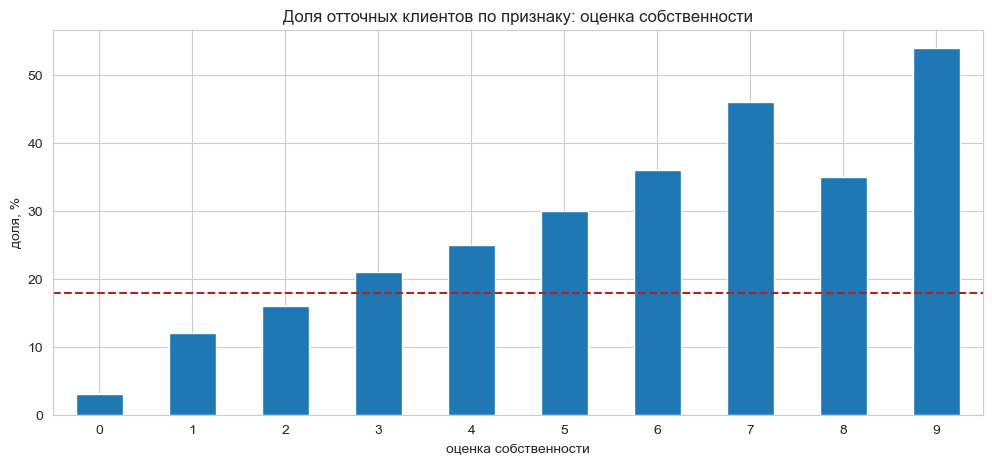

In [80]:
cat_add_value(data, data['equity'], 'оценка собственности')

По признаку 'оценка собственности' 
- отток клиентов, имеющих от 3 до 9 баллов собственности.

##### По признаку 'количество продуктов банка'.

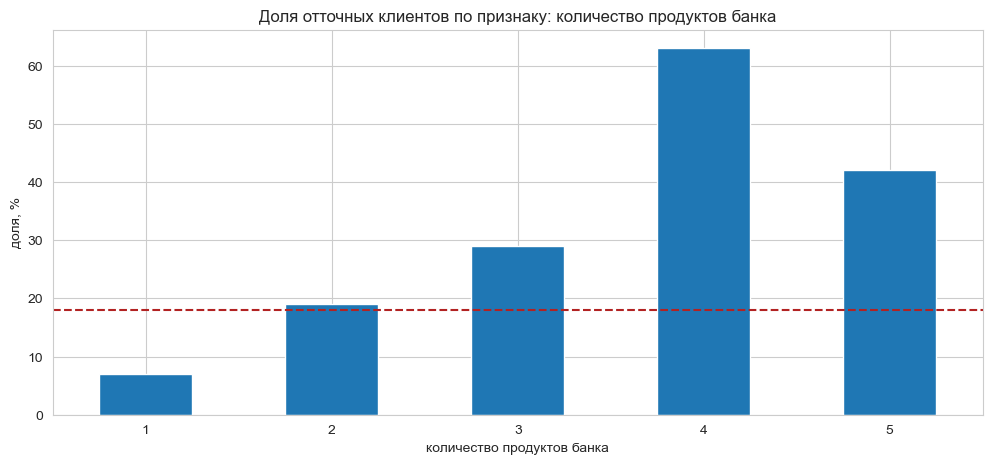

In [81]:
cat_add_value(data, data['products'], 'количество продуктов банка')

По признаку 'количество продуктов банка' 
- отток клиентов, пользующихся  2-5 продуктами банка.

#### Корреляция признаков.

In [82]:
# отберем нужные столбцы и присвоим переменной
data_cor = data_new[['отток', 'баллы скоринга', 'возраст', 'оценка собственности', 'баланс', 'количество продуктов',\
                     'кредитная карта', 'активность клиента', 'доход', 'пол', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']]

In [83]:
# построим матрицу корреляции
corr_matr = data_cor.phik_matrix(interval_cols=['баллы скоринга', 'возраст', 'баланс', 'доход'])

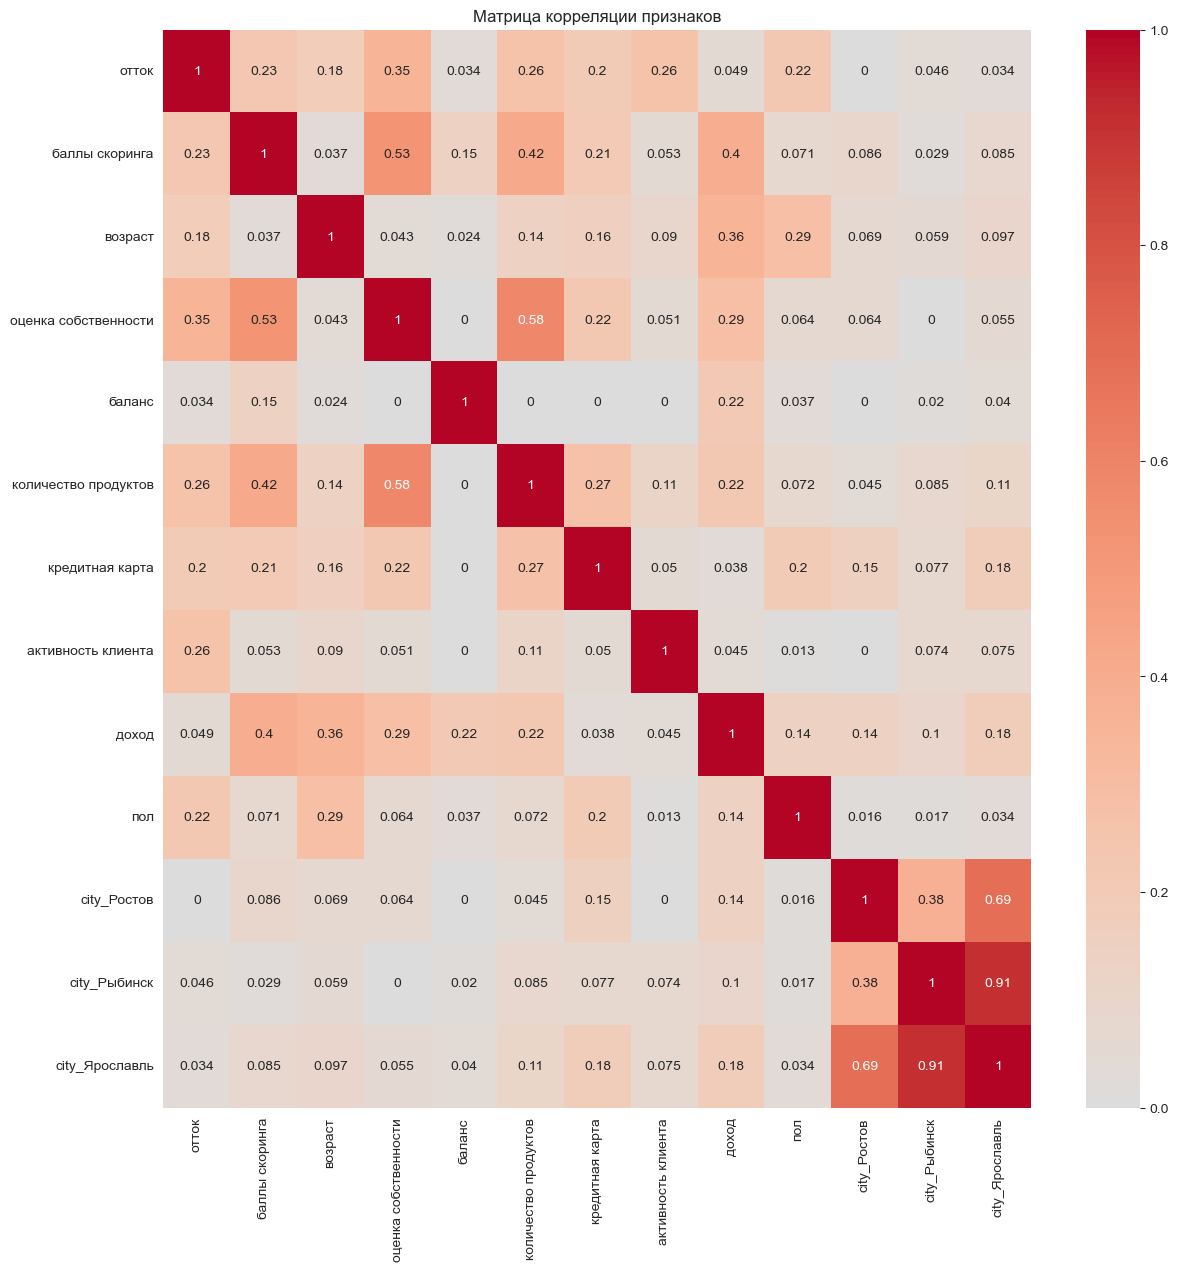

In [84]:
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matr, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

Существует средняя корреляция по шкале Чеддока (по шкале Чеддока корреляция в диапазоне 50–70%  считается средней)
между признаками:
- баллы скоринга - оценка собственности (53%); 
- оценка собственности - количество продуктов банка (58%)

Автоматизированная система оценки платежеспособности заемщика (банковский скоринг) включает в себя в том числе оценку собственности клиента для залога. Отсюда заметная корреляция признаков. 
Чем больше у клиента собственности, тем большими продуктами банка он пользуется, если его устраивают предлагаемые условия. Например, ипотечный кредит предполагает пользование продуктом страхования жизни, высокий депозит - возможностью доверительного управления денежными средствами. Также объяснимая корреляция.


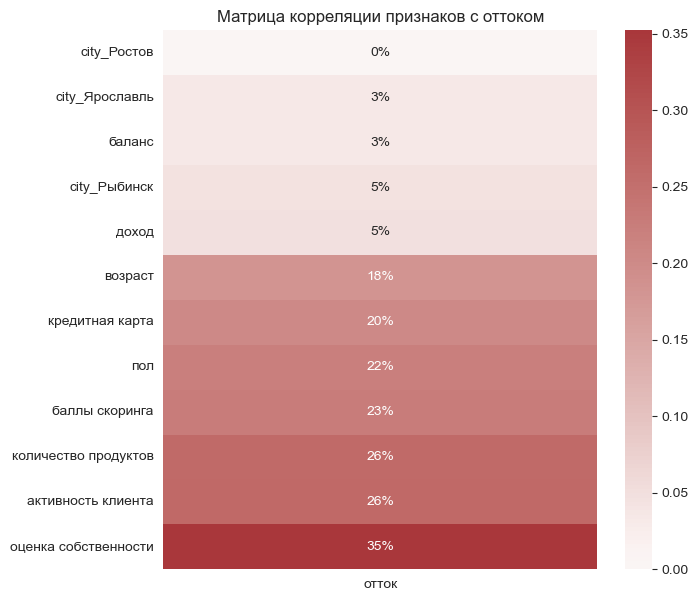

In [85]:
# построим корреляцию признаков с оттоком
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matr.loc[:,['отток']].drop('отток').sort_values('отток'), annot=True, fmt=".0%", cmap='vlag', center=0)
plt.title('Матрица корреляции признаков c оттоком')
plt.show();

Наибольшая корреляция с оттоком по признаку 'оценка собственности', составляет 35%. По шкале Чеддока это слабая корреляция (слабая - в диапазоне  30-50%). По остальным признакам корреляция очень слабая или отсутствует.



### Проверка статистических гипотез.

#### Проверка статистической гипотезы о неравенстве средних значений дохода в группах отток / не отток.

In [86]:
# сделаем срез по группам оттока
data_client = data.query('churn == 0')
data_churn = data.query('churn == 1')

Посмотрим на размеры выборок.

In [87]:
d_cl = data_client['est_salary'].count()
print(f'Количество клиентов в группе оттока {d_cl}.')

Количество клиентов в группе оттока 8155.


In [88]:
d_c = data_churn['est_salary'].count()
print(f'Количество клиентов в группе не оттока {d_c}.')

Количество клиентов в группе не оттока 1818.


Проверим распределения на нормальность по критерию Шапиро-Уилка.

In [89]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(data_client['est_salary'])
p_value = results[1]
  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не отвергаем нулевую гипотезу, распределение нормально')


p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [90]:
results = st.shapiro(data_churn['est_salary'])
p_value = results[1]
  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не отвергаем нулевую гипотезу, распределение нормально')


p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Разница в размерах выборок большая и данные распределены ненормально из-за выбросов. Пропусков  нет, это позволит получить верные результаты.

Проверим условия применения t-теста, должны выполняться условия:

- Генеральные совокупности не зависят друг от друга. Это условие соблюдено. Они разные и независимые.
- Выборочные средние нормально распределены. Это условие не соблюдено. 
- Выборки достаточно велики (30 и больше значений). Это условие соблюдено.

Сравним средние t-тестом, не указывая параметр equal_var: пусть он примет значение True. Применим тест не смотря на большую разницу в выборках и наличие выбросов.

- Ho-средние значения дохода двух совокупностей (отток/не отток) равны.
- H1-среднее значение дохода клиентов оттока  больше среднего значения клиентов группы не оттока.

In [91]:
# задаём уровень значимости
alpha = 0.05

# продолжительность поездок  группы пользователей с подпиской
client_est_salary = data_client['est_salary']

# продолжительность поездок  группы пользователей без подписки
churn_est_salary = data_churn['est_salary']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(churn_est_salary, client_est_salary, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.42504411936290176
Нет оснований отвергнуть нулевую гипотезу


Полученное значение p-value больше заданного уровня значимости, поэтому нулевую гипотезу не отвергаем. Делаем вывод, что статистически значимых различий в доходе  между группами нет, но средние выборок близки.

Из-за наличия выбросов применим непараметрический критерий Манна-Уитни для той же пары гипотез.

Непараметрический критерий U Манна-Уитни применяется для сравнения средних значений двух независимых выборок.

Условия: 

- Сравниваемые значения не составляют пару коррелирующих  значений. Это условие соблюдено.
- Распределение признаков в каждой выборке может не соответствовать нормальному распределению. Это условие соблюдено.

In [92]:
results = st.mannwhitneyu(churn_est_salary, client_est_salary, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.415364594114529e-05
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной. Это значит, что  среднее значение дохода клиентов оттока  больше среднего значения клиентов группы не оттока.

Разница в результатах тестов обусловлена наличием выбросов в выборках. Поэтому принимаем результат u-критерия Манна-Уитни.

#### Проверка статистической гипотезы о неравенстве средних значений баллов оценки собственности в группах отток / не отток.

Как показал график выше оценка собственности коррелирует с оттоком. Подтвердим проверкой гипотезы. Проверим средние значения по группам оттока/ не оттока и сформулируем гипотезы.

- Ho-средние значения баллов оценки собственности двух совокупностей (отток/не отток) равны.
- H1-среднее значение баллов оценки собственности клиентов оттока  больше среднего значения клиентов группы не оттока.

Сначала проверим на нормальность распределения.

In [93]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(data_client['equity'])
p_value = results[1]
  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение ненормально')
else:
    print('Не отвергаем нулевую гипотезу, распределение нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение ненормально


In [94]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(data_churn['equity'])
p_value = results[1]
  

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение ненормально')
else:
    print('Не отвергаем нулевую гипотезу, распределение нормально')

p-значение:  5.356880853081415e-30
Отвергаем нулевую гипотезу: распределение ненормально


В обоих выборках ненормальные распределения. Поэтому применим u-критерий Манна-Уитни.

In [95]:
# продолжительность поездок  группы пользователей с подпиской
client_equity = data_client['equity']

# продолжительность поездок  группы пользователей без подписки
churn_equity = data_churn['equity']

In [96]:
results = st.mannwhitneyu(churn_equity, client_equity, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.0228615425586928e-157
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем в пользу альтернативной. Есть статистически значимые различия между выборками и основания полагать, что среднее значение баллов оценки собственности клиентов группы оттока  больше среднего значения клиентов группы не оттока.

### Промежуточные выводы.

На основании анализа относительной разницы мер центральных тенденций, корреляции признаков с оттоком, изучения диапазонов признаков оттока сделаем промежуточный вывод, что на отток влияют критерии:
- баланс (в диапазоне 800 тыс-120 млн)
- баллы собственности (в диапазоне 3-9),
- баллы скоринга (в диапазоне 810-950),
- пол (мужской),
- возраст (в диапазоне 22-33, 49-60 лет).

### Сегментация клиентов оттока.

По парам-тройкам признаков выведем уровень оттока, количество отточных клиентов и общий размер сегмента. По заданным нам  условиям сегментирования уровень оттока в сегменте должен быть в два раза выше среднего по банку, т.е. выше 36%, размер сегмента 300-2000 клиентов.

#### Сегмент 1:  средний возраст- пол - баланс

In [97]:
balance_age_m = data.query('800000<=balance<=120000000 & gender_copy=="М" & 49<=age<=60')\
                   .agg({'churn':['mean','sum','count']}).reset_index().round(2)
balance_age_m.columns = 'Значение', 'Отток'
balance_age_m['Значение'] = balance_age_m['Значение'].replace({'mean':'Уровень оттока', 'sum':'Количество отточных клиентов',\
                                                               'count': 'Размер сегмента'})
balance_age_m #подходит

,Значение,Отток
0,Уровень оттока,0.54
1,Количество отточных клиентов,168.00
2,Размер сегмента,312.00


Сегмент 1 с уровнем оттока 0,54%, количеством отточных клиентов в сегменте 168 и общим размером сегмента 312 человек. 
Мужчины возраста 49-60 лет, имеющие баланс на счете от 800 тыс. и выше.

#### Сегмент 2: молодой возраст  - баланс.

In [98]:
balance_age_y = data.query('800000<=balance<=120000000  & 22<=age<=33')\
              .agg({'churn':['mean','sum','count']}).reset_index().round(2)
balance_age_y.columns = 'Значение', 'Отток'
balance_age_y['Значение'] = balance_age_y['Значение'].replace({'mean':'Уровень оттока', 'sum':'Количество отточных клиентов',\
                                                               'count': 'Размер сегмента'})
balance_age_y # подходит                                                        

,Значение,Отток
0,Уровень оттока,0.49
1,Количество отточных клиентов,178.00
2,Размер сегмента,364.00


Сегмент 2 с уровнем оттока 0,49%, количеством отточных клиентов в сегменте 178 и общим размером сегмента 364 человека.
Молодые люди возраста 22-33 года, имеющие баланс на счете от 800 тыс. и выше.

In [99]:
balance_gender = data.query('800000<=balance<=120000000  & gender_copy=="М"').agg({'churn':['mean','sum','count']}).round(2).reset_index()
balance_gender #подходит

,index,churn
0,mean,0.46
1,sum,587.00
2,count,1283.00


#### Сегмент 3: баланс-баллы скоринга-баллы собственности.

In [100]:
balance_score_equity = data.query('800000<=balance<=120000000 & 810<=score<=950 & 3<=equity<=9')\
                    .agg({'churn':['mean','sum','count']}).reset_index().round(2)
balance_score_equity.columns = 'Значение', 'Отток' 
balance_score_equity['Значение'] = balance_score_equity['Значение'].replace({'mean':'Уровень оттока', 'sum':'Количество отточных клиентов',\
                                                               'count': 'Размер сегмента'})
balance_score_equity #подходит

,Значение,Отток
0,Уровень оттока,0.41
1,Количество отточных клиентов,736.00
2,Размер сегмента,1806.00


Сегмент 3 с уровнем оттока 0,41%, количеством отточных клиентов в сегменте 736 и общим размером сегмента 1806 человек. Клиенты сегмента имеют высокий балл кредитного скоринга, высокие оценочные баллы недвижимости (3-9) и имеют баланс на счете от 800 тыс. и выше.

In [101]:
balance_equity = data.query('800000<=balance<=120000000 & 3<=equity<=9').agg({'churn':['mean','sum','count']}).round(2)
balance_equity #подходит

,churn
mean,0.36
sum,834.00
count,2302.00


In [102]:
equity_gender = data.query('3<=equity<=9 & gender_copy=="М"').agg({'churn':['mean','sum','count']}).round(2)
equity_gender # не подходит

,churn
mean,0.35
sum,967.00
count,2726.00


In [103]:
age_m_gender = data.query('gender_copy=="М" & 49<=age<=60').agg({'churn':['mean','sum','count']}).round(2)
age_m_gender #не подходит

,churn
mean,0.32
sum,280.00
count,869.00


In [104]:
score_equity = data.query('3<=equity<=9 & 810<=score<=950').agg({'churn':['mean','sum','count']}).round(2)
score_equity #не подходит

,churn
mean,0.31
sum,1263.00
count,4047.00


In [105]:
age_m_score = data.query('810<=score<=950 & 49<=age<=60').agg({'churn':['mean','sum','count']}).round(2)
age_m_score # не подходит

,churn
mean,0.3
sum,390.0
count,1299.0


In [106]:
score_gender = data.query('810<=score<=950 & gender_copy=="М"').agg({'churn':['mean','sum','count']}).round(2)
score_gender #не подходит

,churn
mean,0.28
sum,953.00
count,3346.00


In [107]:
age_y_score = data.query('810<=score<=950 & 22<=age<=33').agg({'churn':['mean','sum','count']}).round(2)
age_y_score # не подходит

,churn
mean,0.27
sum,461.00
count,1680.00


Используя диапазоны значений оттока по признакам вывели 3 сегмента высокоотточных клиентов.

#### Проверка условия охвата отточных клиентов.

По условиям сегментации совокупная сумма отточных клиентов по трем сегментам должна составлять не менее 40% от общего количества отточных клиентов в датасете.

In [108]:
chec = (balance_age_m.loc[1, 'Отток']+balance_age_y.loc[1, 'Отток']+balance_score_equity.loc[1, 'Отток'])/data['churn'].sum()
print(f'Совокупная сумма отточных клиентов по трем сегментам составляет {chec:.2%} от общего количества отточных клиентов в датасете.')

Совокупная сумма отточных клиентов по трем сегментам составляет 59.52% от общего количества отточных клиентов в датасете.


### Выводы и рекомендации для каждого клиента оттока

На основании анализа относительной разницы мер центральных тенденций, корреляции признаков с оттоком, изучения диапазонов признаков оттока делаем вывод, что на отток влияют критерии:
- баланс (в диапазоне 800 тыс-120 млн)
- баллы собственности (в диапазоне 3-9),
- баллы скоринга (в диапазоне 810-950),
- пол (мужской),
- возраст (в диапазоне 22-33, 49-60 лет).

Выделили три сегмента высокоотточных клиентов:

Сегмент 1 с уровнем оттока 0,54%, количеством отточных клиентов в сегменте 168 и общим размером сегмента 312 человек. 
- Мужчины возраста 49-60 лет, имеющие баланс на счете от 800 тыс. и выше.

Сегмент 2 с уровнем оттока 0,49%, количеством отточных клиентов в сегменте 178 и общим размером сегмента 364 человека.
- Молодые люди возраста 22-33 года, имеющие баланс на счете от 800 тыс. и выше.

Сегмент 3 с уровнем оттока 0,41%, количеством отточных клиентов в сегменте 736 и общим размером сегмента 1806 человек. 
- Клиенты сегмента имеют высокий балл кредитного скоринга, высокие оценочные баллы недвижимости (3-9) и имеют баланс на счете от 800 тыс. и выше.

Во всех трех сегментах клиенты имеют высокий баланс на счете. Это VIP-клиенты, требующие эксклюзивного подхода и построения долгосрочных отношений. Поэтому для клиентов этих сегментов нужно персональное обслуживание (контакты, персональные предложения, запрос обратной связи, создание эмоциональной связи, доступ к эксклюзивным продуктам). Поскольку клиенты имеют больщой баланс на счете, можно предложить доверительное управление средствами клиента. Также важно следить за рыночной % ставкой на депозиты и предлагать условия по рынку или чуть ниже. Для всех трех сегментов хорошим решением станут неожиданные подарки.  Кроме этого, учитывая особенности сегментов можно дать следующие рекомендации:

- для клиентов 1 сегмента: т.к. это мужчины среднего возраста, как правило, имеющие семьи, то персонализированные скидки на туры выходного для в хорошие семейные отели/скидки на туристические поездки /скидки в медицинские клиники компаний-партнеров банка могут быть востребованы и способствовать повышению лояльности.

- для клиентов 2 сегмента: т.к. это молодые клиенты, хорошим решением станет интересный контент от банка, программы накопления миль от поездок либо скидки от компаний-партнеров, интересные программы cashback.

- для клиентов 3 сегмента: т.к. клиенты имеют высокие баллы собственности, им можно предложить интересные программы страхования недвижимости, страхования имущества, автомобилей, скидки в салоны  ремонта  и технического обслуживания автомобилей.